In [16]:
%pip install pandas numpy matplotlib scikit-learn pyarrow

%pip freeze > ../requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## Dataset Exploration

In [18]:
"""2023 dataset"""
january_trips_df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

february_trips_df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [19]:
january_trips_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [20]:
january_trips_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [21]:
january_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

**Question 1 - Downloading the data:**
- How many columns are there?

In [22]:
print(f"There are {january_trips_df.shape[1]} columns in January")

There are 19 columns in January


**Question 2 - Computing duration:**
- Compute the trip duration.
- What is the standard deviation of the trips duration duration in January?

In [23]:
january_trips_df["duration_minutes"] = (january_trips_df['tpep_dropoff_datetime'] - january_trips_df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [24]:
print(f"The standard deviation of trips duration in january: {round(january_trips_df['duration_minutes'].std(), 2)}")

The standard deviation of trips duration in january: 42.59


**Question 3 - Dropping outliers:**
- Check the distribution of the duration
- Remove outliers (any record not within 1 and 60 minutes (inclusive))
- What fraction of the records left after you dropped the outliers?

In [25]:
class Plot:
    def __init__(self):
        pass

    def plot_histogram(self, df: pd.DataFrame, column: str, x_label: str = "x axis", y_label: str  = "y axis", title: str = "histogram distribution", color: str = "blue", log: bool = False):
        # plot histogram
        plt.hist(df[column], color=color, log=log, density=True)

        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.title(title)
        
        plt.grid(alpha=0.3)
        
        plt.tight_layout()

        plt.show()

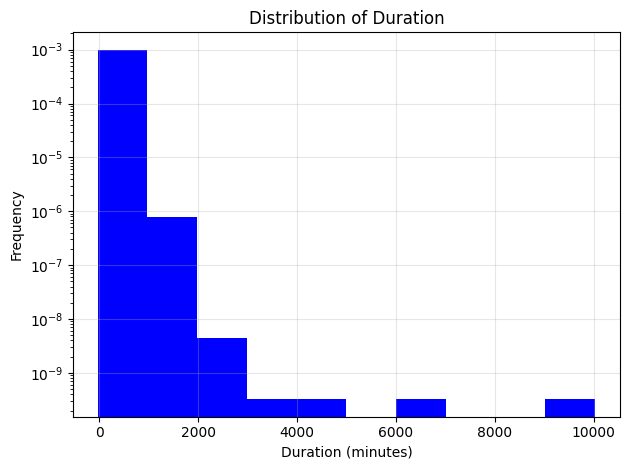

In [26]:
plot = Plot()

# plot histogram to show the distribution of the duration
plot.plot_histogram(
    january_trips_df, 
    "duration_minutes",
    "Duration (minutes)",
    "Frequency",
    "Distribution of Duration",
    log=True
)

In [27]:
"""remove outliers"""
# outliers = january_trips_df[(january_trips_df['duration_minutes'] < 1) | (january_trips_df['duration_minutes'] > 60)]

# valid_df = january_trips_df[~january_trips_df.index.isin(outliers.index)]

def filter_outliers(df: pd.DataFrame, cols: list, rules: list):
    outliers = pd.DataFrame()
    for col, rule in zip(cols, rules):
        if rule.get("min") is not None:
            outliers = pd.concat([outliers, df[df[col] < rule["min"]]])
        if rule.get("max") is not None:
            outliers = pd.concat([outliers, df[df[col] > rule["max"]]])
    outliers = outliers.drop_duplicates()

    valid_df = df[~df.index.isin(outliers.index)]

    return outliers, valid_df
    

In [28]:
outliers, valid_df = filter_outliers(
        january_trips_df,
        cols=["duration_minutes"],
        rules=[{"min": 1, "max": 60}]
    )

In [29]:
print(len(valid_df))
print(len(outliers))

3009173
57593


In [30]:
valid_fraction = (len(valid_df) / len(january_trips_df)) * 100

print(f"The fraction of the records left after dropping outliers is: {round(valid_fraction)}%")

The fraction of the records left after dropping outliers is: 98%


**Question 4 - One-hot encoding:**
- apply one-hot encoding to the pickup and dropoff location IDs (these two features will be used for the model)
- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it
- What's the dimensionality of this matrix (number of columns)?

In [31]:
def apply_one_hot_encoding(df: pd.DataFrame, cols: list = ['PULocationID', 'DOLocationID']):
    for col in cols:
        df[col] = df[col].astype(str)

    # convert to records
    records = df[cols].to_dict("records")

    # add prefix
    for record in records:
        record['pickup_' + record.pop('PULocationID')] = 1
        record['dropoff_' + record.pop('DOLocationID')] = 1

    # apply DictVectorizer
    vectorizer = DictVectorizer(sparse=True)

    vectorizer.fit(records)

    # get the feature matrix
    feature_matrix = vectorizer.transform(records)

    feature_names = vectorizer.get_feature_names_out()

    return feature_matrix, vectorizer, feature_names

In [32]:
# encoder = OneHotEncoder(sparse_output=False)

# categorical_columns = ["PULocationID", "DOLocationID"]

# one_hot_encoded = encoder.fit_transform(valid_df[["PULocationID", "DOLocationID"]])
# one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

feature_matrix, vectorizer, feature_names = apply_one_hot_encoding(valid_df, cols=["PULocationID", "DOLocationID"])

/var/folders/7y/6bp46ck12x1bnxnr0d6pcs440000gn/T/ipykernel_7420/741574140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/var/folders/7y/6bp46ck12x1bnxnr0d6pcs440000gn/T/ipykernel_7420/741574140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)


In [33]:
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Dimensionality of this matrix (number of columns): {feature_matrix.shape[1]}")
# print(f"First 10 feature names: {feature_names[:10]}")
# print(f"Feature matrix (first 3 rows):\n{feature_matrix[:3].toarray()}")

Feature matrix shape: (3009173, 515)
Number of features: 515
Dimensionality of this matrix (number of columns): 515


**Question 5 - Training a model:**
- use the feature matrix from the previous step to train a model.
- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data
- What's the RMSE on train?

In [34]:
X = feature_matrix
y = valid_df['duration_minutes'].values

In [35]:
lr_model = LinearRegression()

lr_model.fit(X, y)

y_pred = lr_model.predict(X)

In [36]:
print(f"The RMSE on the train data (january - vectorized) is: {round(root_mean_squared_error(y, y_pred), 2)}")

The RMSE on the train data (january - vectorized) is: 7.65


Q6. Evaluating the model
- Now let's apply this model to the validation dataset (February 2023).
- What's the RMSE on validation?

In [37]:
february_trips_df["duration_minutes"] = (february_trips_df['tpep_dropoff_datetime'] - february_trips_df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [38]:
feature_matrix, vectorizer, feature_names = apply_one_hot_encoding(february_trips_df)

In [39]:
X = feature_matrix
y = february_trips_df['duration_minutes'].values

In [40]:
# Remove outliers from february_trips_df
feb_outliers, feb_valid_df = filter_outliers(
        february_trips_df,
        cols=["duration_minutes"],
        rules=[{"min": 1, "max": 60}]
)

In [41]:
# Apply one-hot encoding to filtered dataframe
feature_matrix, _, _ = apply_one_hot_encoding(feb_valid_df, cols=["PULocationID", "DOLocationID"])

/var/folders/7y/6bp46ck12x1bnxnr0d6pcs440000gn/T/ipykernel_7420/741574140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)
/var/folders/7y/6bp46ck12x1bnxnr0d6pcs440000gn/T/ipykernel_7420/741574140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str)


In [42]:
X = feature_matrix
y = feb_valid_df['duration_minutes'].values

lr_model.fit(X, y)
y_pred = lr_model.predict(X)

In [43]:
print(f"The RMSE on the validation data (february - vectorized) is: {round(root_mean_squared_error(y, y_pred), 2)}")

The RMSE on the validation data (february - vectorized) is: 7.78
